# Working with biological sequences 

In [3]:
import evolutron.tools as et

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

### Transforming the protein sequence into an 1-hot representation

In [37]:
amino_acids = list(et.aa_map.keys())

In [38]:
aa_seq = 'MFLLWYFCLLST'
aa_hot = et.aa2hot(aa_seq)

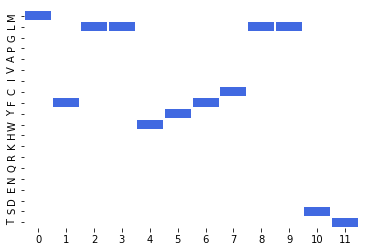

In [39]:
fig, ax = plt.subplots(1,1) 
sns.heatmap(aa_hot.T, ax=ax, yticklabels=amino_acids, linewidths=1, cmap=['white', 'royalblue'], cbar=False)
plt.show()

In [40]:
dna_seq = 'GTAYGGGRTN'
dna_hot = et.nt2prob(dna_seq)

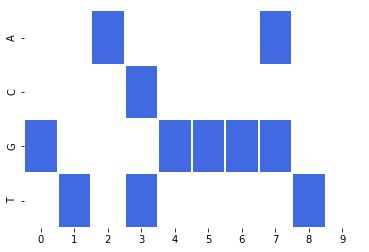

In [42]:
fig, ax = plt.subplots(1,1) 
sns.heatmap(dna_hot.T, ax=ax, yticklabels=['A','C','G','T'], linewidths=1, cmap=['white', 'royalblue'], cbar=False)
plt.show()